## Toxic Comment Classification

This is a multi label classification challenge with each of the targets being binary in nature. We need to classify if a comment belongs to one or more categories.



Following are the targets:



Toxic

Severe_toxic

Obscene

Threat

Insult

Identity_hate

Evaluation: average of the individual AUCs of each predicted target



### Approach

Basic EDA - Visualization, data problems and fixes

Data Cleaning and Visualization

Data Transformation

Non-semantic baseline

WIP - Semantic embeddings, baseline


## EDA


In [1]:
!pip install matplotlib-venn


  Created wheel for matplotlib-venn: filename=matplotlib_venn-0.11.6-py3-none-any.whl size=32067 sha256=a8935c08372de745c5accde1b017245d3d72adf47999d51e444cd664f0feed89
  Stored in directory: c:\users\acer\appdata\local\pip\cache\wheels\82\e4\64\dd790d424818bc2f59c11471a1eee5dc8cfcd3f8ee8c4812fa
Successfully built matplotlib-venn


In [4]:
!pip install plotnine[all]

  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.0
    Uninstalling statsmodels-0.12.0:
      Successfully uninstalled statsmodels-0.12.0


In [6]:
!pip install wordsegment

In [9]:
!pip install scikit-multilearn

In [12]:
!pip install gensim

In [14]:
!pip install python-Levenshtein

  Running setup.py clean for python-Levenshtein
Failed to build python-Levenshtein
    Running setup.py install for python-Levenshtein: started
    Running setup.py install for python-Levenshtein: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\acer\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\acer\\AppData\\Local\\Temp\\pip-install-gn3i85hi\\python-levenshtein\\setup.py'"'"'; __file__='"'"'C:\\Users\\acer\\AppData\\Local\\Temp\\pip-install-gn3i85hi\\python-levenshtein\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\acer\AppData\Local\Temp\pip-wheel-t3sopxls'
       cwd: C:\Users\acer\AppData\Local\Temp\pip-install-gn3i85hi\python-levenshtein\
  Complete output (27 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.8
  creating build\lib.win-amd64-3.8\Levenshtein
  copying Levenshtein\StringMatcher.py -> build\lib.win-amd64-3.8\Levenshtein
  copying Levenshtein\__init__.py -> build\lib.win-amd64-

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotnine import *
from matplotlib_venn import venn3, venn3_circles

import re
import logging
import itertools
import unicodedata
import string
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('en_core_web_sm')
# import contractions

from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize
from IPython.display import Markdown as md

from wordsegment import load, segment
load()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

import warnings
warnings.filterwarnings("ignore")

C:\Users\acer\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.


In [15]:
train_df = pd.read_csv('D:/train.csv')
test_df = pd.read_csv('D:/test.csv')
sample_submission_df = pd.read_csv('D:/sample_submission.csv')
test_labels_df = pd.read_csv('D:/test_labels.csv')

In [16]:
print("shape of train data : ", train_df.shape)
print("shape of test data : ", test_df.shape)
print("first 5 rows of train data :")
train_df.head()

shape of train data :  (159571, 8)
shape of test data :  (153164, 2)
first 5 rows of train data :


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Sample comments corresponding to each category

In [17]:
for i in ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']:
    print("{} :".format(i.upper()))
    print(train_df.loc[train_df[i]==1, 'comment_text'].sample().values[0][:500], "\n")

TOXIC :
Hi enemy

You will NEVER be able to get rid of me faggot. 

SEVERE_TOXIC :
YOU FUCKING SUCK I HATE YOUR FUCKING SITE IT SUCKS ASS! 

OBSCENE :
I'm sorry 

I am sorry that I was an ass to you on this site. Sorry for vandalizing your pages, and making death threats. I just do not like Sureños. It was quite rude of me. I will not do it again. Thanks for your time, and please do not see this apology as vandalism.72.13.91.132 

THREAT :
Terrorize 
I will terrorise you for as long as you live - you are an arrogant, disgusting and rude excuse for a human being & you are going to die soon so I suggest you stop threatening people you bastard. 

INSULT :
LOSER QUESTION 

Any reason why you can't mind your own fucking business? Ever kissed a girl? I don't think so, at least not an attractive one

Get the FUCK out of articles you don't understand, loser 

IDENTITY_HATE :
NIGGERS!
Dows really matter to label them? as long as they are dead. 



In [18]:
## plots for EDA :

plt.style.use("seaborn-pastel")
def category_percentage(df):
    df['clean'] = np.where((df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0), 1,0)
    
    categories = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'clean']
    plot_data = df[categories].mean()*100

    plt.figure(figsize=(10,5))
    plt.title("percentage records by category")
    sns.barplot(x=plot_data.index, y = plot_data.values)
    plt.show()
    
    return

def text_length_across_classes(df):
    df['comment_length'] = df['comment_text'].apply(lambda x : len(x.split()))
    
    median_text_len = []
    mean_text_len = []
    min_text_len = []
    max_text_len = []
    max_distinct_tokens = []
    
    for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
        mean_text_len.append(df[df[i]==1]['comment_length'].mean())  
        min_text_len.append(df[df[i]==1]['comment_length'].min())  
        max_text_len.append(df[df[i]==1]['comment_length'].max())  
        median_text_len.append(df[df[i]==1]['comment_length'].median())  
        df['distinct_tokens'] = df['comment_text'].apply(lambda x : len(set(x.split())))
        max_distinct_tokens.append(df[df[i]==1]['distinct_tokens'].max())
        
    mean_text_len.append(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0)]['comment_length'].mean())
    min_text_len.append(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0)]['comment_length'].min())
    max_text_len.append(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0)]['comment_length'].max())
    median_text_len.append(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0)]['comment_length'].median())
    max_distinct_tokens.append(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0)]['distinct_tokens'].max())
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    sns.barplot(ax=axes[0,0], x=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','clean'], 
                y=median_text_len)
    axes[0,0].set_title('median text length')
    sns.barplot(ax=axes[0,1], x=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','clean'], 
                y=min_text_len)
    axes[0,1].set_title('minimum text length')
    sns.barplot(ax=axes[1,0], x=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','clean'], 
                y=max_text_len)
    axes[1,0].set_title('max text length')
    sns.barplot(ax=axes[1,1], x=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','clean'], 
                y=max_distinct_tokens)
    axes[1,1].set_title('max distinct tokens')

    fig.suptitle('text length statistics')
    plt.show()
    
    return 

def corr_between_labels(df):
    plt.figure(figsize=(15,8))
    plt.title("correlation between toxic categories")
    sns.heatmap(df.corr(),cmap='YlGnBu',annot=True)
    plt.show()
    return 

## Gram statistics
def gram_analysis(data,gram):
    stop_words_set = set(stopwords.words('english'))
    tokens=[t for t in data.lower().split(" ") if t!="" if t not in stop_words_set]
    ngrams=zip(*[tokens[i:] for i in range(gram)])
    final_tokens=[" ".join(z) for z in ngrams]
    return final_tokens

def gram_freq(df, gram, categ_col, text_col):
    category_text = " ".join(df[df[categ_col]==1][text_col].sample(200).values)
    toks = gram_analysis(category_text, gram)
    tok_freq = pd.DataFrame(data=[toks, np.ones(len(toks))]).T.groupby(0).sum().reset_index()
    tok_freq.columns = ['token','frequency']
    tok_freq = tok_freq.sort_values(by='frequency',ascending=False)
    
    plt.figure(figsize=(10,8))
    plt.title("{} most common tokens".format(categ_col))
    sns.barplot(x='token', y='frequency', data=tok_freq.iloc[:30])
    plt.xticks(rotation=90)
    plt.show()
    
    return 

def avg_word_len_plot(df):
    # word distribution across categories
    df['punct_count'] = df['comment_text'].apply(lambda x : len([a for a in x if a in string.punctuation]))
    df['avg_word_length'] = df['comment_text'].apply(lambda x : np.round(np.mean([len(a) for a in x.split()])))
    
    clean = df[df['clean']==1].avg_word_length.value_counts().reset_index()
    clean.columns = ['length', 'frequency']
    print("clean comments max token length : {}".format(max(clean.length)))
    clean = clean.sort_values(by='length')
    plt.figure(figsize=(20,7))
    plt.title("Average word length - clean comments")
    sns.barplot(x=clean.length, y=clean.frequency)
    plt.xticks(rotation = 90)
    plt.show()

    toxic = df[df['clean']==0].avg_word_length.value_counts().reset_index()
    toxic.columns = ['length', 'frequency']
    print("toxic comments max token length : {}".format(max(toxic.length)))
    toxic = toxic.sort_values(by='length')
    plt.figure(figsize=(20,7))
    plt.title("Average word length -toxic comments (all forms)")
    sns.barplot(x=toxic.length, y=toxic.frequency)
    plt.xticks(rotation = 90)
    plt.show()
    
    return 

def generate_wordclouds(df, text_col, categ_col):
    df['clean'] = np.where((df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0), 1,0)
    
    if categ_col=='all_toxic':
        category_text = df[df['clean']!=1][text_col].values
    else:
        category_text = df[df[categ_col]==1][text_col].values
               
    plt.figure(figsize=(15,8))
    wc = WordCloud(background_color="black", 
                   max_words=5000, 
                   stopwords=STOPWORDS, 
                   collocations=False,
                   max_font_size= 40)
    wc.generate(" ".join(category_text))
    plt.title("{} word cloud".format(categ_col), fontsize=20)
    # plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
    plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
    plt.axis('off')
    
    plt.show()
    
    return 

def venn_(df):
    figure, axes = plt.subplots(2,2,figsize=(20,20))
    toxic = set(df[df['toxic']==1].index)
    severe_toxic = set(df[df['severe_toxic']==1].index)
    obscene = set(df[df['obscene']==1].index)
    threat = set(df[df['threat']==1].index)
    insult = set(df[df['insult']==1].index)
    identity_hate = set(df[df['identity_hate']==1].index)
    clean = set(df[df['clean']==1].index)

    v1 = venn3([toxic, severe_toxic, obscene],
          set_labels=('Toxic','Severe toxic','Obscene'), set_colors=('#a5e6ff', '#3c8492','#9D8189'), ax=axes[0][0])
    for text in v1.set_labels:
        text.set_fontsize(22)
    v2 = venn3([threat, insult, identity_hate],
          set_labels=('Threat','Insult','Identity hate'), set_colors=('#e196ce', '#F29CB7','#3c81a9'), ax=axes[0][1])
    for text in v2.set_labels:
        text.set_fontsize(22)
    v3 = venn3([toxic, insult, obscene],
          set_labels=('Toxic','Insult','Obscene'), set_colors=('#a5e6ff', '#F29CB7','#9D8189'), ax=axes[1][0])
    for text in v3.set_labels:
        text.set_fontsize(22)
    v4 = venn3([threat, identity_hate, obscene],
          set_labels=('Threat','Identity hate','Obscene'), set_colors=('#e196ce', '#3c81a9','#9D8189'), ax=axes[1][1])
    for text in v4.set_labels:
        text.set_fontsize(22)
    plt.show()
    
    # deleting used variables
    del toxic
    del severe_toxic
    del obscene
    del threat
    del insult
    del identity_hate
    del clean
    
    return

def meta_data_analysis(df, text_col):
    meta_df = pd.DataFrame()
    meta_df['punctuations'] = df[text_col].apply(lambda x : len([a for a in str(x) if a in string.punctuation]))
    meta_df['hashtags'] = df[text_col].apply(lambda x : len([a for a in x.split() if a.startswith("#")]))
    meta_df['usernames'] = df[text_col].apply(lambda x : len([a for a in x.split() if a.startswith("@")]))
    meta_df['stop_words'] = df[text_col].apply(lambda x : len([a for a in x.lower().split() if a in STOPWORDS]))
    meta_df['upper_case_words'] = df[text_col].apply(lambda x : len([a for a in x.split() if a.isupper()]))
    meta_df['urls'] = df[text_col].apply(lambda x : len([a for a in x.split() if a.startswith(tuple(['http', 'www']))]))
    meta_df['word_count'] = df[text_col].apply(lambda x : len(x.split()))
    meta_df['distinct_word_count'] = df[text_col].apply(lambda x : len(set(x.split())))
    meta_df['clean'] = df['clean'].copy()
    
    return meta_df

Percentage of data vs Category

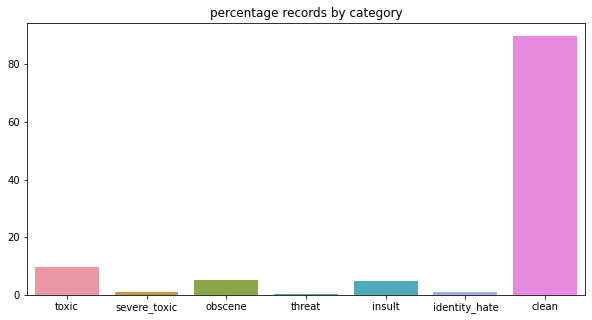

89.83% of the comments are clean i.e., non-toxic


In [19]:
category_percentage(train_df)
print("{}% of the comments are clean i.e., non-toxic".format(np.round(100*train_df['clean'].sum()/train_df.shape[0],2)))
perc_clean_data = np.round(100*train_df['clean'].sum()/train_df.shape[0],2)

This is clearly as case with high class imbalance



## Correlation and Interrelation

### Correlation between labels:

#### Insult and Obscene, Toxic and obscene exhibit a strong correlation


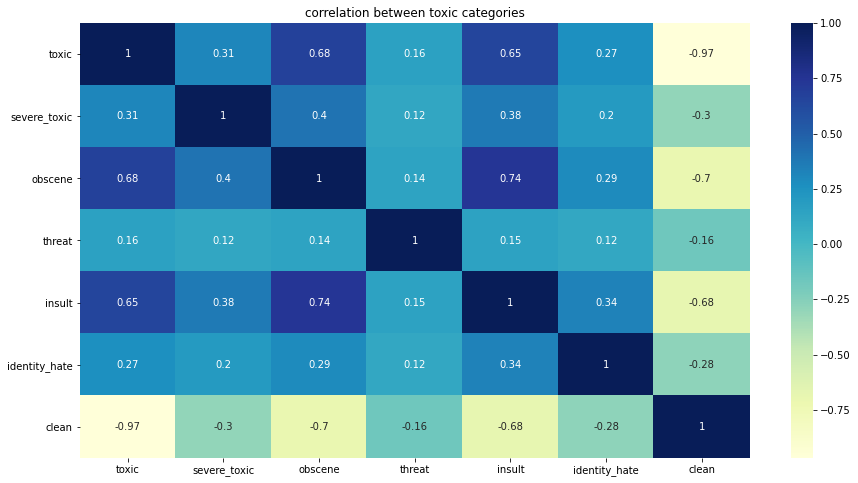

In [21]:
corr_between_labels(train_df)


### Interrelation between categories

#### All severe toxic comments are toxic


#### Most severe toxic comments are also obscene in nature


#### toxic, insult and obscene comments share a good amount of overlap


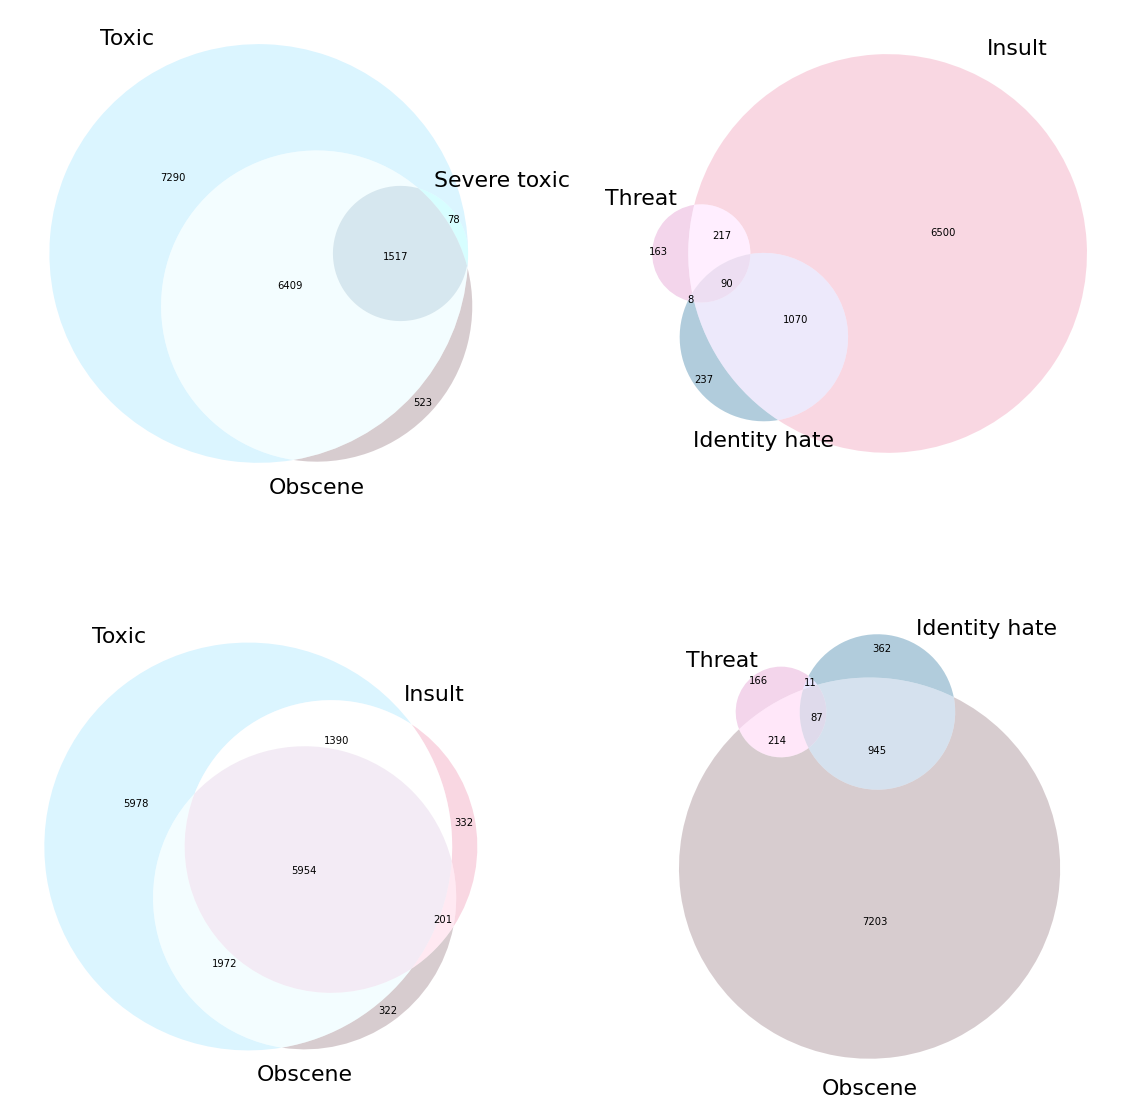

In [23]:
venn_(train_df)


## Meta data analysis

### Comment length statistics across categories

#### There is an observable difference between median length of clean and toxic data
#### The difference in max text length and max distinct tokens raises suggests possibility of heavy word repetition

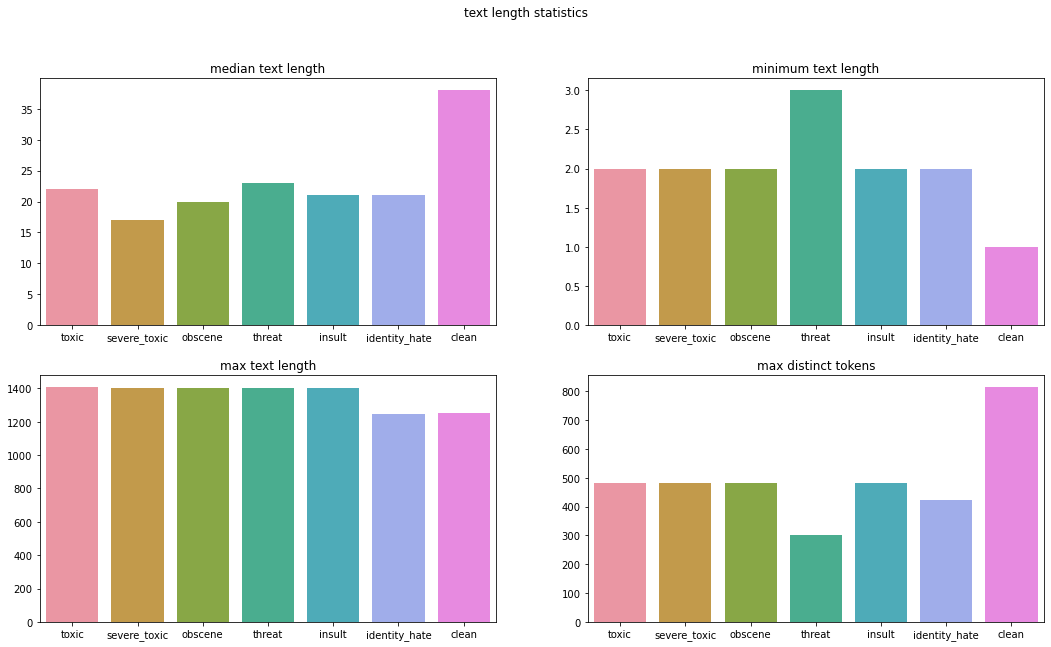

In [24]:
text_length_across_classes(train_df)


### Average word length in clean and toxic comments.

The average word length in both clean and toxic comments is unreasobaly high;


we need to clean the data and inspect further, if the issue persists

clean comments max token length : 709.0


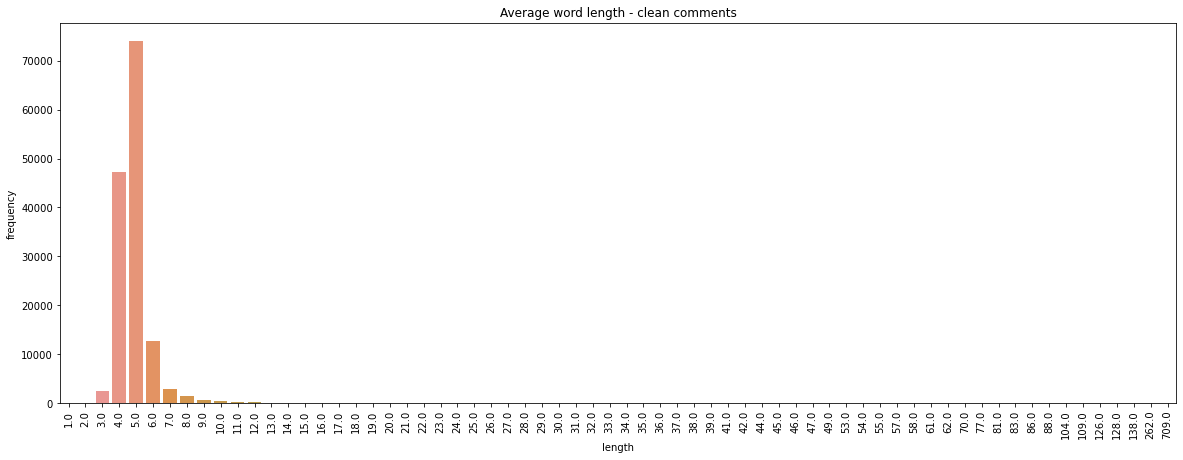

toxic comments max token length : 1655.0


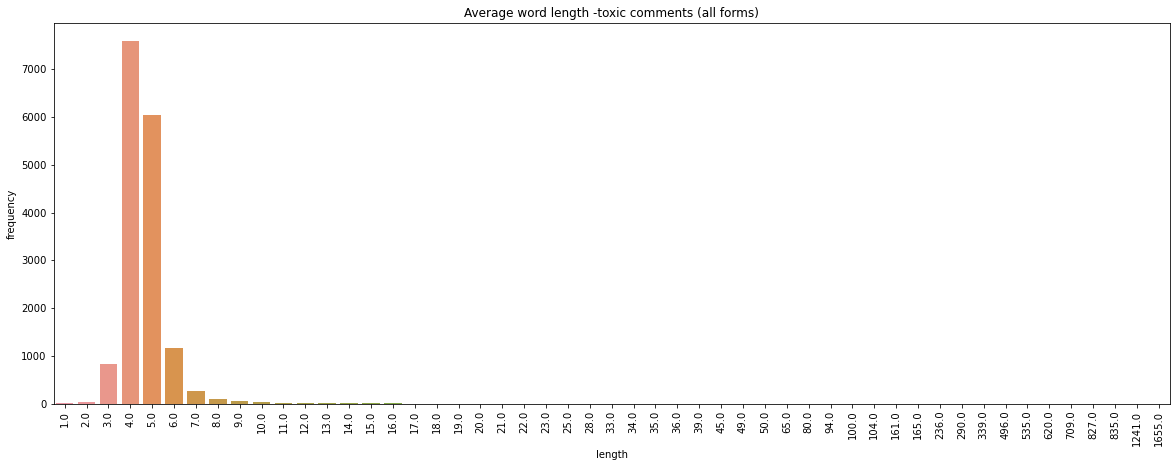

In [26]:
avg_word_len_plot(train_df)


### Wordclouds - unprocessed data

We observe a heavy use of upper-cased, racist text (offensive nouns) in toxic comments

Clean comments on the other had fewer nouns and no observable upper case text

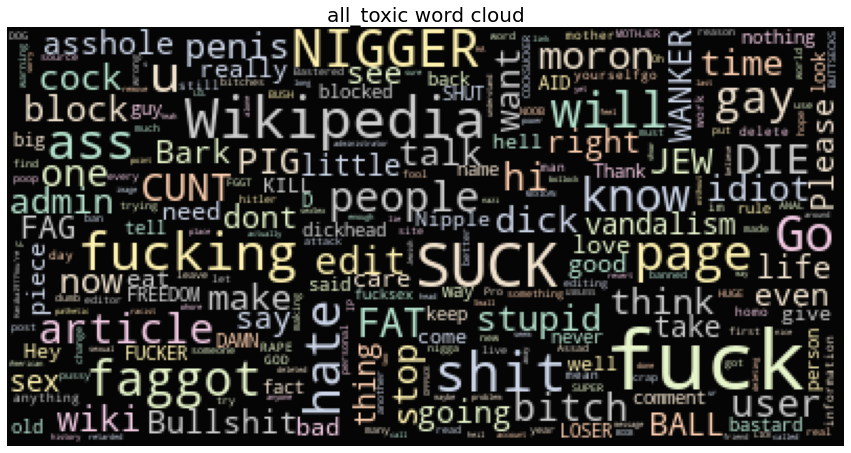

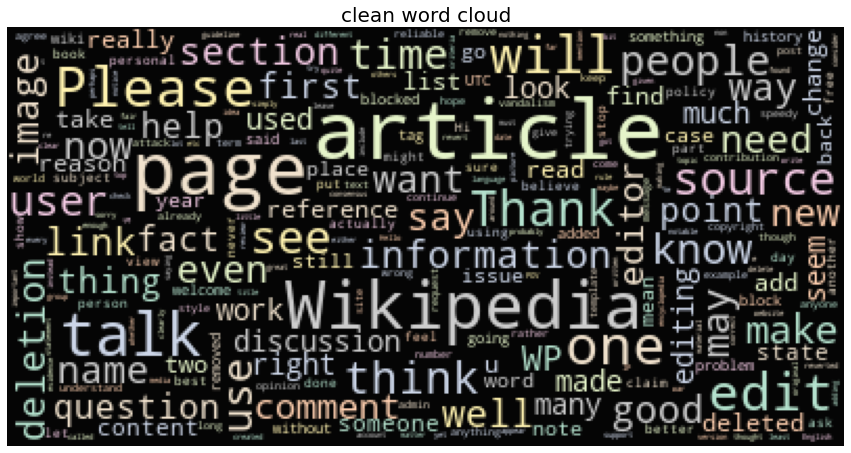

In [27]:
# Word cloud using raw data

generate_wordclouds(train_df, 'comment_text', 'all_toxic')
generate_wordclouds(train_df, 'comment_text', 'clean')

## Text cleaning
Next step is to remove unnecessary elements from text.

It is important to note that this "unnecessary text" elimination process could be more successful when followed in a particular sequence.

For instance, elimination of special characters before removal of hashtags, usernames defeats our purpose as the text following a '#' could be considered a token (ex: #kaggledays -> kaggledays).

Here is the sequence we will implement:


HTML codes (if present)

URLs/ email addresses

Hashtags/Usernames

Emojis

Stopwords

Expanding Abbreviations

Punctuations

Special characters/ Numbers


In [28]:
## Text cleaning

class TextCleaningUtils:
    '''
        This class contains implementations of various text cleaning operations (Static Methods)
    '''
    @staticmethod
    def expand_abbreviations(text):
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"there's", "there is", text)
        text = re.sub(r"We're", "We are", text)
        text = re.sub(r"That's", "That is", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"they're", "they are", text)
        text = re.sub(r"Can't", "Cannot", text)
        text = re.sub(r"wasn't", "was not", text)
        text = re.sub(r"don\x89Ûªt", "do not", text)
        text= re.sub(r"aren't", "are not", text)
        text = re.sub(r"isn't", "is not", text)
        text = re.sub(r"What's", "What is", text)
        text = re.sub(r"haven't", "have not", text)
        text = re.sub(r"hasn't", "has not", text)
        text = re.sub(r"There's", "There is", text)
        text = re.sub(r"He's", "He is", text)
        text = re.sub(r"It's", "It is", text)
        text = re.sub(r"You're", "You are", text)
        text = re.sub(r"I'M", "I am", text)
        text = re.sub(r"shouldn't", "should not", text)
        text = re.sub(r"wouldn't", "would not", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"i'm", "I am", text)
        text = re.sub(r"I\x89Ûªm", "I am", text)
        text = re.sub(r"I'm", "I am", text)
        text = re.sub(r"Isn't", "is not", text)
        text = re.sub(r"Here's", "Here is", text)
        text = re.sub(r"you've", "you have", text)
        text = re.sub(r"you\x89Ûªve", "you have", text)
        text = re.sub(r"we're", "we are", text)
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"we've", "we have", text)
        text = re.sub(r"it\x89Ûªs", "it is", text)
        text = re.sub(r"doesn\x89Ûªt", "does not", text)
        text = re.sub(r"It\x89Ûªs", "It is", text)
        text = re.sub(r"Here\x89Ûªs", "Here is", text)
        text = re.sub(r"who's", "who is", text)
        text = re.sub(r"I\x89Ûªve", "I have", text)
        text = re.sub(r"y'all", "you all", text)
        text = re.sub(r"can\x89Ûªt", "cannot", text)
        text = re.sub(r"would've", "would have", text)
        text = re.sub(r"it'll", "it will", text)
        text = re.sub(r"we'll", "we will", text)
        text = re.sub(r"wouldn\x89Ûªt", "would not", text)
        text = re.sub(r"We've", "We have", text)
        text = re.sub(r"he'll", "he will", text)
        text = re.sub(r"Y'all", "You all", text)
        text = re.sub(r"Weren't", "Were not", text)
        text = re.sub(r"Didn't", "Did not", text)
        text = re.sub(r"they'll", "they will", text)
        text = re.sub(r"DON'T", "DO NOT", text)
        text = re.sub(r"That\x89Ûªs", "That is", text)
        text = re.sub(r"they've", "they have", text)
        text = re.sub(r"they'd", "they would", text)
        text = re.sub(r"i'd", "I would", text)
        text = re.sub(r"should've", "should have", text)
        text = re.sub(r"You\x89Ûªre", "You are", text)
        text = re.sub(r"where's", "where is", text)
        text = re.sub(r"Don\x89Ûªt", "Do not", text)
        text = re.sub(r"i'll", "I will", text)
        text = re.sub(r"weren't", "were not", text)
        text = re.sub(r"They're", "They are", text)
        text = re.sub(r"Can\x89Ûªt", "Cannot", text)
        text = re.sub(r"you\x89Ûªll", "you will", text)
        text = re.sub(r"I\x89Ûªd", "I would", text)
        text = re.sub(r"let's", "let us", text)
        text = re.sub(r"it's", "it is", text)
        text = re.sub(r"can't", "cannot", text)
        text = re.sub(r"don't", "do not", text)
        text = re.sub(r"you're", "you are", text)
        text = re.sub(r"i've", "I have", text)
        text = re.sub(r"that's", "that is", text)
        text = re.sub(r"i'll", "I will", text)
        text = re.sub(r"doesn't", "does not",text)
        text = re.sub(r"i'd", "I would", text)
        text = re.sub(r"didn't", "did not", text)
        text = re.sub(r"ain't", "am not", text)
        text = re.sub(r"you'll", "you will", text)
        text = re.sub(r"I've", "I have", text)
        text = re.sub(r"Don't", "do not", text)
        text = re.sub(r"I'll", "I will", text)
        text = re.sub(r"I'LL", "I will", text)
        text = re.sub(r"I'd", "I would", text)
        text = re.sub(r"Let's", "Let us", text)
        text = re.sub(r"you'd", "You would", text)
        text = re.sub(r"It's", "It is", text)
        text = re.sub(r"Ain't", "am not", text)
        text = re.sub(r"Haven't", "Have not", text)
        text = re.sub(r"Hadn't", "Had not", text)
        text = re.sub(r"Could've", "Could have", text)
        text = re.sub(r"youve", "you have", text)  
        text = re.sub(r"donå«t", "do not", text)  

        return text

    cleaning_regex_map = {
        'web_links': r'(?i)(?:(?:http(?:s)?:)|(?:www\.))\S+',
        'email': r'[\w.]+@\w+\.[a-z]{3}',
        'twitter_handles': r'[#@]\S+',
        'redundant_newlines': r'[\r|\n|\r\n]+',
        'redundant_spaces': r'\s\s+',
        'punctuations': r'[\.,!?;:]+',
#         'special_chars': r'[^a-zA-Z0-9\s\.,!?;:]+',
        'special_chars': r'[^a-zA-Z\s\.,!?;:]+'  ## removing nums
        
    }
    
    @staticmethod
    def clean_text_from_regex(text, text_clean_regex):
        '''
            Follow a particular cleaning expression, provided
            as an input by an user to clean the text.
        '''

        text = text_clean_regex.sub(' ', text).strip()
        return text
    
    @staticmethod
    def strip_html(text):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
    
    @staticmethod
    def remove_web_links(text):
        '''
            Removes any web link that follows a particular default expression,
            present in the text.
        '''

        web_links_regex = re.compile(TextCleaningUtils.cleaning_regex_map['web_links'])
        text = TextCleaningUtils.clean_text_from_regex(text, web_links_regex)
        return text
    
    @staticmethod
    def remove_email_addresses(text):
        '''
            Removes email addresses present in the text.
        '''

        email_regex = re.compile(TextCleaningUtils.cleaning_regex_map['email'])
        text = TextCleaningUtils.clean_text_from_regex(text, email_regex)
        return text
    
    @staticmethod
    def remove_twitter_handles(text):
        '''
            Removes any twitter handle present in the text.
        '''

        twitter_handles_regex = re.compile(TextCleaningUtils.cleaning_regex_map['twitter_handles'])
        text = TextCleaningUtils.clean_text_from_regex(text, twitter_handles_regex)
        return text
    
    @staticmethod
    def remove_emojis(text):
        emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        text=emoji_clean.sub(r'',text)
        url_clean= re.compile(r"https://\S+|www\.\S+")
        text=url_clean.sub(r'',text)
        return text
    
    @staticmethod
    def remove_redundant_newlines(text):
        '''
            Removes any redundant new line present in the text.
        '''

        redundant_newlines_regex = re.compile(
            TextCleaningUtils.cleaning_regex_map['redundant_newlines'])
        text = TextCleaningUtils.clean_text_from_regex(text, redundant_newlines_regex)
        return text
    
    @staticmethod
    def remove_redundant_spaces(text):
        '''
            Remove any redundant space provided as default,
            that is present in the text.
        '''

        redundant_spaces_regex = re.compile(
            TextCleaningUtils.cleaning_regex_map['redundant_spaces'])
        text = TextCleaningUtils.clean_text_from_regex(text, redundant_spaces_regex)
        return text
    
    @staticmethod
    def remove_punctuations(text):
        '''
            Removes any punctuation that follows the default expression, in the text.
        '''

        remove_punctuations_regex = re.compile(TextCleaningUtils.cleaning_regex_map['punctuations'])
        text = TextCleaningUtils.clean_text_from_regex(text, remove_punctuations_regex)
        return text

    @staticmethod
    def remove_special_chars(text):
        '''
            Replace any special character provided as default,
            which is present in the text with space
        '''

        special_chars_regex = re.compile(TextCleaningUtils.cleaning_regex_map['special_chars'])
        text = TextCleaningUtils.clean_text_from_regex(text, special_chars_regex)
        return text

    @staticmethod
    def remove_exaggerated_words(text):
        '''
            Removes any exaggerated word present in the text.
        '''

        return ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))

    @staticmethod
    def replace_multiple_chars(text):
        '''
            Replaces multiple characters present in the text.
        '''

        char_list = ['.', '?', '!', '#', '$', '/', '@', '*', '(', ')', '+']
        final_text = ''
        for i in char_list:
            if i in text:
                pattern = "\\" + i + '{2,}'
                repl_str = i.replace("\\", "")
                text = re.sub(pattern, repl_str, text)
                final_text = ' '.join(text.split())
        return final_text

    @staticmethod
    def replace_sign(text):
        '''
            Replaces any sign with words like & with 'and', in the text.
        '''
        sign_list = {'&': ' and ', '/': ' or ', '\xa0': ' '}
        final_text = ''
        for i in sign_list:
            if i in text:
                text = re.sub(i, sign_list[i], text)
                final_text = ' '.join(text.split())
        return final_text

    @staticmethod
    def remove_accented_char(text):
        text = unicodedata.normalize('NFD', text) \
            .encode('ascii', 'ignore') \
            .decode("utf-8")
        return str(text)

    @staticmethod
    def replace_characters(text, replace_map):
        '''
            Replaces any character custom provided by an user.
        '''

        for char, replace_val in replace_map.items():
            text = text.replace(char, replace_val)
        return text
    
def clean_data(df,col_to_clean):
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_web_links)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_email_addresses)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_twitter_handles)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.expand_abbreviations)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_emojis)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_special_chars)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_redundant_spaces)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_punctuations)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_exaggerated_words)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_redundant_newlines)
    df[col_to_clean] = df[col_to_clean].astype(str)
    df[col_to_clean] = df[col_to_clean].str.lower()
    
    return df

In [29]:
%%time
train_df = clean_data(train_df, 'comment_text')

Wall time: 47.7 s


### Average word lengths acrcoss toxic and clean comment categories (after cleaning)

#### Word lengths still look unusual!

clean comments max token length : 30.0


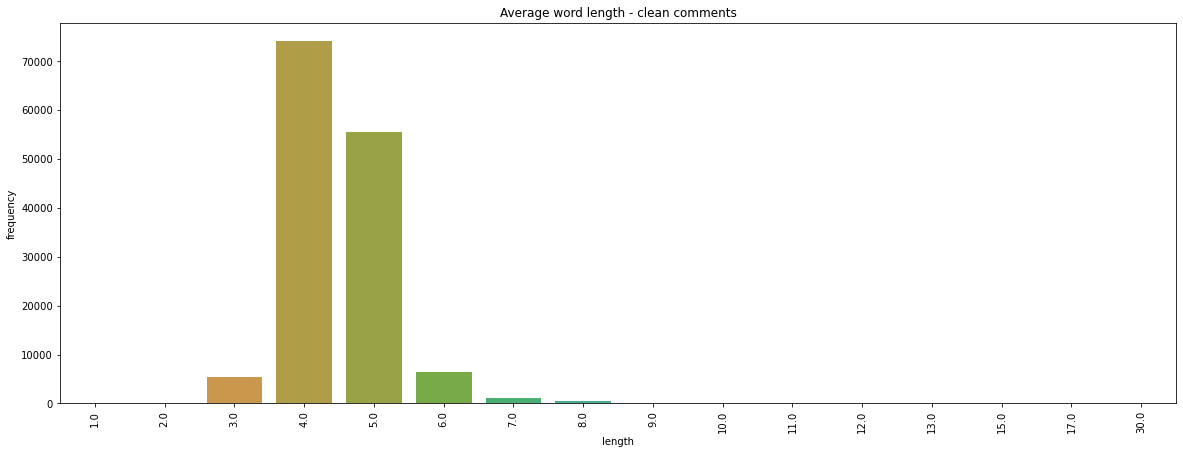

toxic comments max token length : 1240.0


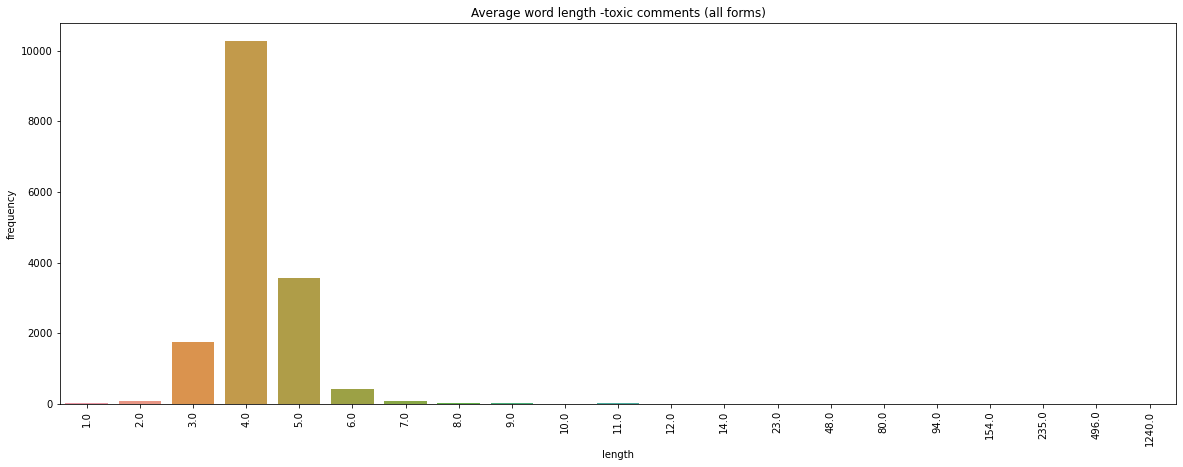

In [31]:
avg_word_len_plot(train_df)


Let's take a minute to see what is an acceptable word length in english

Distribution of distinct word lengths - English

In [32]:
category_text = train_df[train_df['clean']!=1]['comment_text'].values
category_text = " ".join(category_text)
long_len_words = [word for word in category_text.split() if len(word)>20]
print("num of long length words in toxic(all forms) text : {}".format(len(long_len_words)))
long_len_words[:5]

num of long length words in toxic(all forms) text : 392


['foreverlosttinkerbell',
 'encyclopediadramatica',
 'hahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahaha',
 'lolololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololol',
 'cuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcunti']

### Apart from the long token problem seen above, we have another issue

It is the issue of repetitive phrases/lines in comments

Comments with text repetition can cause computational overload.


It's best to trim such text to its basic, non-repetitve form to preserve the meaning and also to make computation efficient.
sample text of the above nature in this dataset is as follows:

In [33]:
train_df[(train_df['comment_length']>100) & (train_df['distinct_tokens']<30)].comment_text.sample().values[0][:500]

'bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum bum '

### Data specific text preprocessing

#### Addresses the following issues:


long words (formed by repetitive characters)

long texts (formed by repetitive words)

spaceless phrases (ex: idontlikethisline)

In [34]:
class data_specific_preprocessing:
    
    @staticmethod
    def long_word_cleaning(wrd):
        if wrd.startswith('haha') | wrd.startswith('ahah'):
            wrd = 'haha'
        elif wrd.startswith('lol') | wrd.startswith('olo'):
            wrd = 'lol'
        elif wrd.startswith('fuckfuck') | wrd.startswith('uckfuc') | wrd.startswith('ckfuck') | wrd.startswith('kfuckf'):
            wrd = 'fuck'
        elif wrd.startswith('suck') | wrd.startswith('ucks') | wrd.startswith('cksu') | wrd.startswith('ksuc'):
            wrd = 'suck'
        elif wrd.startswith('mwahaha') | wrd.startswith('muahaha'):
            wrd = 'muahahaha'
        elif wrd.startswith('bwahaha'):
            wrd = 'bwahaha'
        elif wrd.startswith('cunt') | wrd.startswith('untc') | wrd.startswith('ntcu') | wrd.startswith('tcun'):
            wrd = 'cunt'
        elif wrd.startswith('blah'):
            wrd = 'blah'
        elif wrd.startswith('tytyty'):
            wrd = 'ty'
        return wrd
    
    @staticmethod
    def long_word_fix(text):
        x = text.split()
        # fixes long words
        x = [data_specific_preprocessing.long_word_cleaning(wrd) if len(wrd)>20 else wrd for wrd in x]
        # returns words from spaceless phrases
        text = " ".join([" ".join(segment(wrd)) if len(wrd)>20 else wrd for wrd in x])
        return text
    
    @staticmethod
    def repetitive_text_cleaning(text):
        x = text.split()
        if len(x)>100 and len(set(x))<=30:
            text = " ".join(x[:len(set(x))+10])
        return text

In [35]:
%%time
train_df['comment_text'] = train_df['comment_text'].apply(data_specific_preprocessing.long_word_fix)
train_df['comment_text'] = train_df['comment_text'].apply(data_specific_preprocessing.repetitive_text_cleaning)

Wall time: 18.9 s


clean comments max token length : 17.0


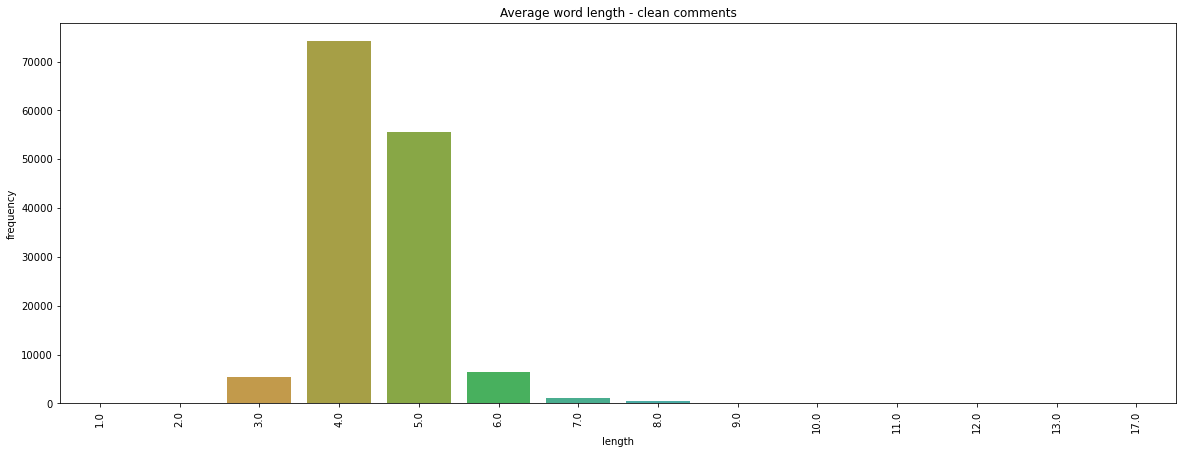

toxic comments max token length : 18.0


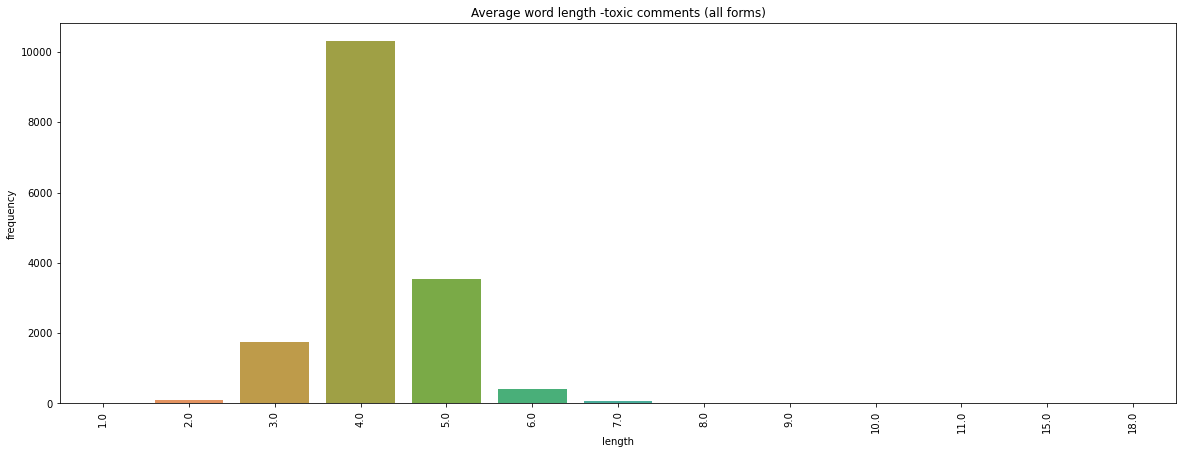

In [36]:
avg_word_len_plot(train_df)


We have now achieved reasonable word lengths in both toxic and non-toxic groups of data



### Bi-gram analysis


Most common bigrams in each category

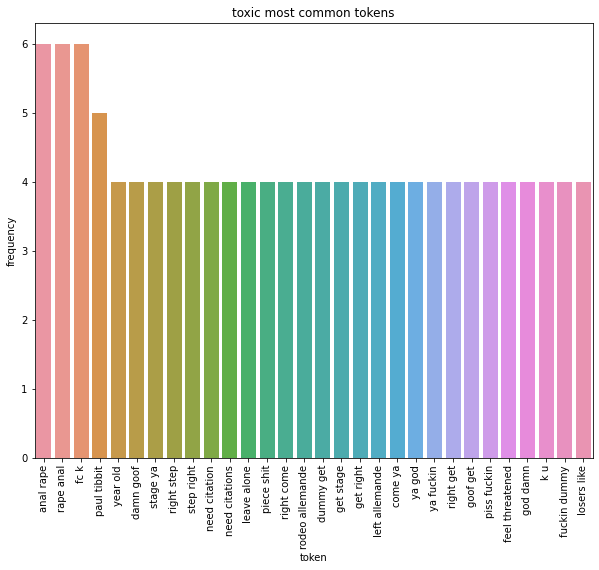

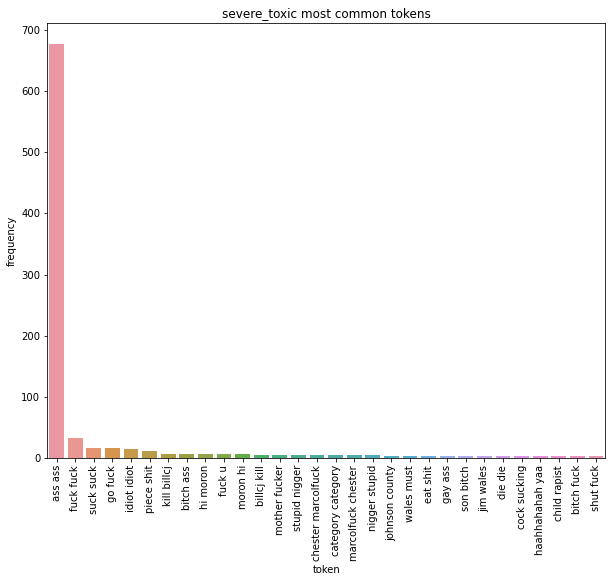

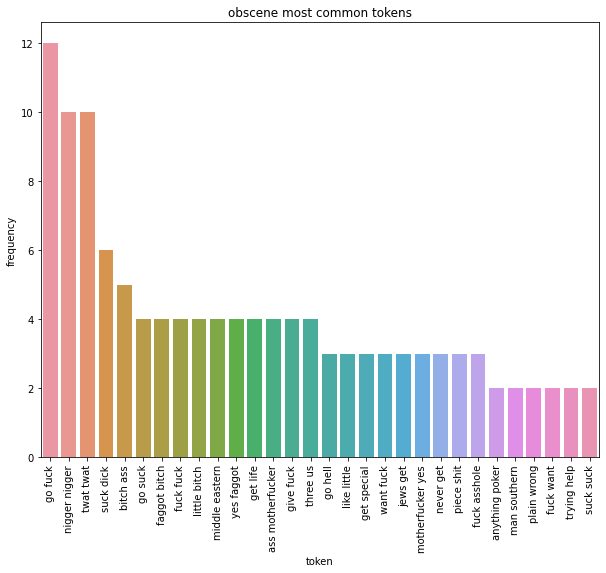

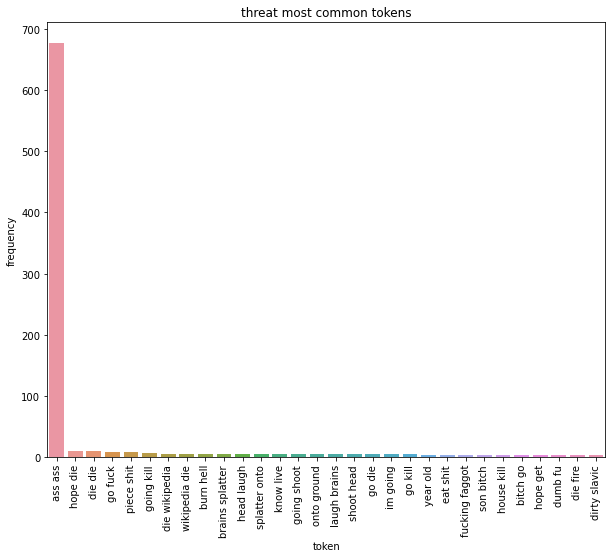

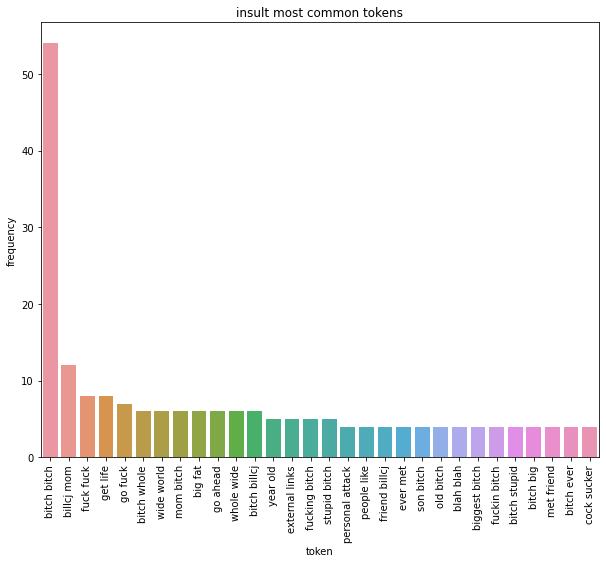

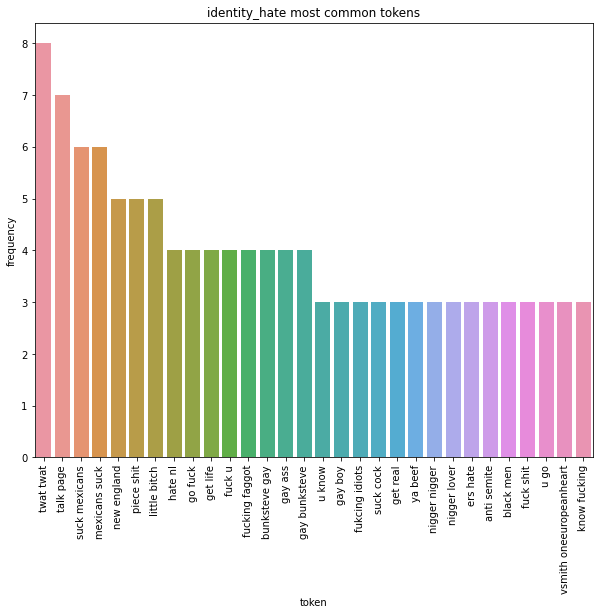

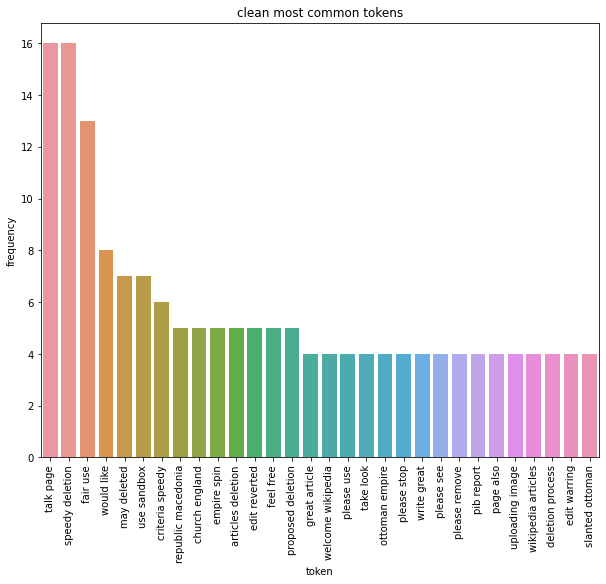

In [37]:
for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'clean']:
    gram_freq(train_df,2, i, 'comment_text')

Clean comments don't appear to revolve around particular pattern given the frequency of common bigrams observed


Toxic (severe_toxic, obscene) comments on the other hand tend to be more specific given the frequently occurring bigrams


we could perform a similar exercise with trigrams to observe commonly occurring three word combinations

## Text transformation

#### Using lemmatization to convert words to their base form


In [38]:
%%time
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

def text_transformation(text):
    lemm_words = " ".join([lemm.lemmatize(word) for word in text.split()])    
    return lemm_words
                        
train_df['comment_text'] = train_df['comment_text'].apply(text_transformation)


Wall time: 38.7 s


In [39]:
# train validation split
tr_df, val_df = train_test_split(train_df, test_size=0.25, random_state=0)

### Non-semantic Approaches

Bag of words techniques do not take into consideration the order of words in a given text. These techniques are primarily concerned with number of occurences of words in the text.

There are three ways in which we could vectorize text:

Count Vectorizer

Tfidf Vectorizer

Hashing Vectorizer

Here's a useful resource that discusses these techniques in detail getting started with nlp feature vectors

### Count vectorizer baseline

### TF-IDF baseline

In [40]:
%%time
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3), analyzer='word', 
                                   strip_accents='unicode',token_pattern=r'\w{1,}', use_idf=1,
                                   smooth_idf=1,sublinear_tf=1)

# tfidf_vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,3))
train_tfidf = tfidf_vectorizer.fit_transform(tr_df['comment_text'])
val_tfidf =  tfidf_vectorizer.transform(val_df['comment_text'])

target_category = []
aucs = []
for target in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    target_category.append(target)
    lr = LogisticRegression(C=2, class_weight='balanced', max_iter=1000)
    lr.fit(train_tfidf, tr_df[target])
    lr_val_pred = lr.predict(val_tfidf)
    print("model for {} category".format(target))
    auc_score = roc_auc_score(val_df[target], lr_val_pred)
    aucs.append(auc_score)
    print("validation auc : ", auc_score, "\n")

print("avg auc : ", np.mean(aucs))

model for toxic category
validation auc :  0.8941981847880724 

model for severe_toxic category
validation auc :  0.9040469695795187 

model for obscene category
validation auc :  0.9280197713120344 

model for threat category
validation auc :  0.815680749886315 

model for insult category
validation auc :  0.9074358325527238 

model for identity_hate category
validation auc :  0.8513584002076371 

avg auc :  0.883456651387717
Wall time: 11min 56s


## Semantic embeddings WIP


### Static embeddings

#### These are vector space representations of words in the corpus.



###### Commonly used static embeddings are:



Word2vec

GloVe

Fasttext


We will be using Glove vectors in word2vec format here

In [49]:
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_reg_100d_file = ('D:/glove.6B.100d.txt')
word2vec_output_file = ('D:/glove.6B.100d.txt.word2vec')
glove_loaded = glove2word2vec(glove_input_file=glove_reg_100d_file, word2vec_output_file=word2vec_output_file)
print(glove_loaded)

(400000, 100)


In [50]:
%%time
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

Wall time: 41.7 s


In [51]:
def mean_word_embedding(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word in glove_model.index2word]
    sum_emb = np.array(100)
    if len(words)>=1:
        for i in words:
            sum_emb = sum_emb + glove_model[i]
    return sum_emb/len(words)

#### mean embeddings of comments from different categories

In [52]:
# mean embeddings of sample comments from categories

tox = train_df[train_df['toxic']==1].comment_text.sample().values[0]
obs = train_df[train_df['obscene']==1].comment_text.sample().values[0]
thre = train_df[train_df['threat']==1].comment_text.sample().values[0]
iden = train_df[train_df['identity_hate']==1].comment_text.sample().values[0]
sevtox = train_df[train_df['severe_toxic']==1].comment_text.sample().values[0]
ins = train_df[train_df['insult']==1].comment_text.sample().values[0]
clean = train_df[train_df['clean']==1].comment_text.sample().values[0]


plt.plot(mean_word_embedding(sevtox), label='severe toxic')
plt.plot(mean_word_embedding(ins), label='insult')
plt.plot(mean_word_embedding(clean), label='clean')
plt.plot(mean_word_embedding(thre), label='threat')
plt.legend()
plt.show()

AttributeError: The index2word attribute has been replaced by index_to_key since Gensim 4.0.0.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4